# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

Значение метрики качества *F1* не меньше 0.75.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
#загрузим необходимые библиотеки
import os
import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm
from sklearn.pipeline import Pipeline

from tqdm import notebook
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import RandomizedSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import (MultinomialNB,
                                GaussianNB)
from sklearn.svm import SVC


from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix



In [2]:
#прочитаем и посмотрим данные

pth1 = './toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    df_comments = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df_comments = pd.read_csv(pth2)
else:
    print('Something is wrong')


df_comments.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


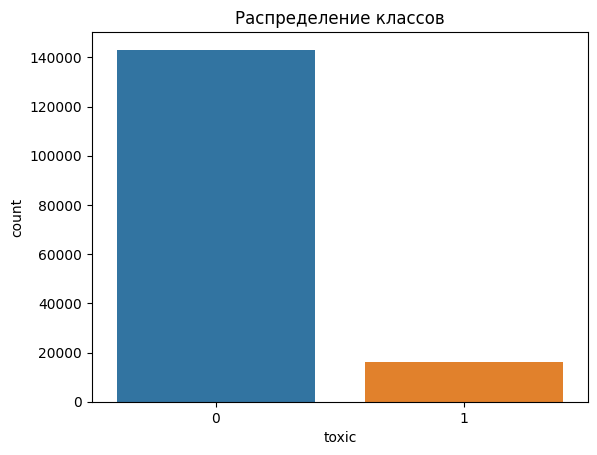

In [4]:
#посмотрим дисбаланс классов
sns.countplot(data=df_comments, x="toxic" )
plt.title("Распределение классов") # заголовок

None

Таким образом имеются текстовые данные комментариев людей. В выборке обнаружен дисбаланс классов, что может привести к увеличенной ошибке второго рода(пропуск цели, потому что именно целевых комментариев у нас недостаток). Далее данные подлежат очистке и обработке для приведения их к необходимому для моделей виду.

### Очистка текста

In [5]:
def clear_text(text):
    text = str(text).lower() # текст в нижний регистр
    text = re.sub(r'[^a-zA-Z\' ]', ' ', text)
    text = [w for w in text.split() if len(w) >= 3] # удаляем слова короче 3х символов
    clear_text = " ".join(text)
    return clear_text

nltk.download('stopwords')
stop_words = stopwords.words('english')

def del_stopwords(text):
    clean_tokens = tuple(
        map( lambda x: x if x not in stop_words else '', word_tokenize(text) )
    )

    res_text = ' '.join(clean_tokens)
    return res_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
#применим функцию очистки
df_comments['text'] = df_comments['text'].apply(clear_text)


In [10]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
df_comments['text'] = df_comments['text'].apply(del_stopwords)

In [12]:
df_comments['text'].head()

0    explanation   edits made  username hardcore me...
1    d'aww matches  background colour  'm seemingly...
2    hey man  'm really  trying edit war  's    guy...
3     ca n't make  real suggestions improvement won...
4                sir  hero  chance  remember  page  's
Name: text, dtype: object

### Лемматизация

In [13]:
nltk.download('wordnet')

nltk.download('averaged_perceptron_tagger')

nltk.download('omw-1.4')

wnl = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [14]:
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n',
                  'JJ':'a',
                  'VB':'v',
                  'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'


def lemmatize_sent(text):
    lemm_text = [wnl.lemmatize(word, pos=penn2morphy(tag)) #.lower()
            for word, tag in pos_tag(word_tokenize(text))]
    res_text = ' '.join(lemm_text)
    return res_text


In [15]:
tqdm.pandas()

df_comments['lemmtext'] = df_comments['text'].progress_apply(lemmatize_sent)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [16]:
df_comments['lemmtext'].head()

0    explanation edits make username hardcore metal...
1    d'aww match background colour 'm seemingly stu...
2    hey man 'm really try edit war 's guy constant...
3    ca n't make real suggestion improvement wonder...
4                     sir hero chance remember page 's
Name: lemmtext, dtype: object

## Разделение на выборки

In [17]:
#вариант для варианта с изменённым столбцом
features_train, features_test = train_test_split(df_comments['lemmtext'], test_size=0.1, random_state=42, shuffle=False)

target_train, target_test = train_test_split(df_comments['toxic'], test_size=0.1, random_state=42, shuffle=False)

## Обучение для TfidfVectorize

#### LogisticRegression

In [24]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", LogisticRegression()),
    ]
)

parameter_grid = {
    "vect__max_features" : [5_000, 10_000, 30_000],
    "clf__solver":['saga'],
    "clf__penalty": ['l1', 'l2'],
    "clf__C" : range (5, 10),
    "clf__class_weight" : ['balanced', None]
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter_grid,
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs= -1,
    )

In [25]:
%%time
warnings.filterwarnings('ignore') #отключаем предупреждения
random_search.fit(features_train, target_train)

CPU times: user 33.1 s, sys: 6.88 s, total: 40 s
Wall time: 1h 16min 18s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                             ('clf', LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions={'clf__C': range(5, 10),
                                        'clf__class_weight': ['balanced', None],
                                        'clf__penalty': ['l1', 'l2'],
                                        'clf__solver': ['saga'],
                                        'vect__max_features': [5000, 10000,
                                                               30000]},
                   random_state=42, scoring='f1')

In [26]:
print("Лучшие параметры:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

print(
    "F1 на лучших параметрах "
    f": {random_search.best_score_:.3f}"
)


Лучшие параметры:
clf__C: 9
clf__class_weight: None
clf__penalty: l2
clf__solver: saga
vect__max_features: 5000
F1 на лучших параметрах : 0.772


#### MultinomialNB - байессовский классификатор

In [27]:
pipeline_2 = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", MultinomialNB()),
    ]
)

parameter_grid = {
    "clf__fit_prior": [True, False]
}

random_search_2 = RandomizedSearchCV(
    estimator=pipeline_2,
    param_distributions=parameter_grid,
    scoring='f1',
    cv=5,
    random_state=42
    )

In [28]:
%%time
warnings.filterwarnings('ignore') #отключаем предупреждения
random_search_2.fit(features_train, target_train)

CPU times: user 50.1 s, sys: 303 ms, total: 50.4 s
Wall time: 50.6 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                             ('clf', MultinomialNB())]),
                   param_distributions={'clf__fit_prior': [True, False]},
                   random_state=42, scoring='f1')

In [29]:
print("Лучшие параметры:")
best_parameters = random_search_2.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

print(
    "F1 на лучших параметрах "
    f": {random_search_2.best_score_:.3f}"
)


Лучшие параметры:
clf__fit_prior: False
F1 на лучших параметрах : 0.607


## Обучение для CountVectorizer

#### LogisticRegression

In [34]:
pipeline_3 = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("clf", LogisticRegression()),
    ]
)

parameter_grid = {
    "vect__max_features" : [5_000, 10_000, 30_000],
    "clf__solver":['saga'],
    "clf__penalty": ['l1', 'l2'],
    "clf__C" : range (5, 10),
    "clf__class_weight" : ['balanced', None]
}

random_search_3 = RandomizedSearchCV(
    estimator=pipeline_3,
    param_distributions=parameter_grid,
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs= -1,
    )

In [35]:
%%time
warnings.filterwarnings('ignore') #отключаем предупреждения
random_search_3.fit(features_train, target_train)

CPU times: user 52.9 s, sys: 8.91 s, total: 1min 1s
Wall time: 1h 51min 5s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('clf', LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions={'clf__C': range(5, 10),
                                        'clf__class_weight': ['balanced', None],
                                        'clf__penalty': ['l1', 'l2'],
                                        'clf__solver': ['saga'],
                                        'vect__max_features': [5000, 10000,
                                                               30000]},
                   random_state=42, scoring='f1')

In [36]:
print("Лучшие параметры:")
best_parameters = random_search_3.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

print(
    "F1 на лучших параметрах "
    f": {random_search_3.best_score_:.3f}"
)


Лучшие параметры:
clf__C: 5
clf__class_weight: balanced
clf__penalty: l2
clf__solver: saga
vect__max_features: 30000
F1 на лучших параметрах : 0.517


#### MultinomialNB - байессовский классификатор

In [37]:
pipeline_4 = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("clf", MultinomialNB()),
    ]
)

parameter_grid = {
    "clf__fit_prior": [True, False]
}

random_search_4 = RandomizedSearchCV(
    estimator=pipeline_4,
    param_distributions=parameter_grid,
    scoring='f1',
    cv=5,
    random_state=42
    )

In [38]:
%%time
warnings.filterwarnings('ignore') #отключаем предупреждения
random_search_4.fit(features_train, target_train)

CPU times: user 49.7 s, sys: 460 ms, total: 50.1 s
Wall time: 50.3 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('clf', MultinomialNB())]),
                   param_distributions={'clf__fit_prior': [True, False]},
                   random_state=42, scoring='f1')

In [39]:
print("Лучшие параметры:")
best_parameters = random_search_4.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

print(
    "F1 на лучших параметрах "
    f": {random_search_4.best_score_:.3f}"
)


Лучшие параметры:
clf__fit_prior: True
F1 на лучших параметрах : 0.714


## Тестирование

Протестируем логистическую регрессию для tfidf векторизации

In [30]:
tfidf_vectorizer = TfidfVectorizer(max_features = 5000)

tfidf_train = tfidf_vectorizer.fit_transform(features_train.astype(str))
tfidf_test = tfidf_vectorizer.transform(features_test.astype(str))

In [31]:
model = LogisticRegression(penalty='l2', C=9.0, class_weight=None, random_state=42, solver='saga')
model.fit(tfidf_train, target_train)

predictions = model.predict(tfidf_test)
f1 = f1_score(target_test, predictions)

print(f1)

0.7728353140916807


## Выводы

Полученные данные были очищены: удалены лишние символы и стоп слова, проведена лемматизация. Далее было применено два вида векторизации, а также для каждого вида были применены 2  модели, которые показали следующие результаты:


**Для tfidf_vectorizer**

 - LogisticRegression 0.77
 - MultinomialNB 0.60

**Для CountVectorizer**

 - LogisticRegression 0.52
 - MultinomialNB 0.72

Для тестирования выбрана модель логистической регрессии с применением tfidf_vectorizer, посколько она дает наибольшее значение необходимой метрики, а также довольно быстро работает.

На тестовых данных получено следующее значение метрики: *f1 = 0.77*, что удовлетворяет условию.


## Улучшения

1) Попробовать Берт

2) Поработать с дисбалансом классов и минимизировать ошибку второго рода
